# Modeling notebook
**Author: Vala Rahmani**

Importing all the required packages

In [69]:
import pandas as pd
import numpy as np
from nltk import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier, RandomForestClassifier
#Import Library of Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from nltk.classify import NaiveBayesClassifier

#Importing the Bayes and the Vader for the Sentiment Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib.pyplot as plt


#Use this line to see all the columns
pd.set_option('display.max_columns', 40)

Import the clean csv here the csv has been formatted in the EDA notebook.

In [3]:
data = pd.read_csv('dataset/clean_data_vegan.csv')

In [4]:
# Drop the values of the clean_title that were not saved into csv
data.dropna(subset = ['clean_title'],axis = 0, inplace=True)

In [5]:
data['clean_title_selftext'].isna().sum()

0

**The positive class for the modeling purposes will be the subreddit Vegan however the subreddit_paleo will be used for the graphing purposes.**

In [6]:
sia = SentimentIntensityAnalyzer()

In [7]:
list_of_scores = []
for post in data['clean_title_selftext']:
    scores = sia.polarity_scores(post)
    list_of_scores.append(scores)
data['vader_score'] = list_of_scores

In [8]:
data.head(2)


,id,author,is_video,name,num_comments,score,selftext,title,ups,subreddit_vegan,title_selftext,clean_title,clean_title_selftext,vader_score
0,a0k6zx,arav24,False,t3_a0k6zx,0,0,Hi guys! I am majoring in Nutritional Science ...,I'm a 18 year old aspiring blogger [blogspam],0,0,I'm a 18 year old aspiring blogger [blogspam] ...,year old aspiring blogger,year old aspiring blogger hi guys majoring nut...,"{'neg': 0.0, 'neu': 0.542, 'pos': 0.458, 'comp..."
1,cb2t2d,techguySF,False,t3_cb2t2d,0,0,NaN,Did Bone Marrow make us Human? [Discussion],0,0,Did Bone Marrow make us Human? [Discussion],bone marrow make us human,bone marrow make us human,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


In [9]:
# Create a positive class for the paleo for graphing purposes
data['subreddit_paleo'] = [1 if i==0 else 0 for i in data['subreddit_vegan']]

In [10]:
data.tail(2)

,id,author,is_video,name,num_comments,score,selftext,title,ups,subreddit_vegan,title_selftext,clean_title,clean_title_selftext,vader_score,subreddit_paleo
1781,cbp9c1,stenle99,False,t3_cbp9c1,1,45,NaN,Made some Veggie Pho the other day. A lot of e...,45,1,Made some Veggie Pho the other day. A lot of e...,made veggie pho day lot effort searching aroun...,made veggie pho day lot effort searching aroun...,"{'neg': 0.0, 'neu': 0.685, 'pos': 0.315, 'comp...",0
1782,cbme6u,Joey_x_G,False,t3_cbme6u,1,89,NaN,Found this little mad ting on r/Tinder,89,1,Found this little mad ting on r/Tinder,found little mad ting r tinder,found little mad ting r tinder,"{'neg': 0.421, 'neu': 0.579, 'pos': 0.0, 'comp...",0


### Train Test Split for the data

In [11]:
#********************************** Vegan Paleo Train Test Split *******************************#
from sklearn.model_selection import train_test_split
features = [i for i in data.columns if i!='subreddit_vegan']
X_train, X_test, y_train, y_test = train_test_split(data[features],
                                                data['subreddit_vegan'],
                                                random_state=42,
                                                stratify=data['subreddit_vegan'])


In [13]:
X_train[['clean_title','clean_title_selftext','vader_score']].head(2)

,clean_title,clean_title_selftext,vader_score
19,enlightened halo top ice cream friendly,enlightened halo top ice cream friendly fine k...,"{'neg': 0.118, 'neu': 0.294, 'pos': 0.588, 'co..."
1033,belated th july burger,belated th july burger,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


In [14]:
print(f'X_train{X_train.shape}')
print(f'y_train{y_train.shape}')
print(f'X_test{X_test.shape}')
print(f'y_test{y_test.shape}')

X_train(1323, 14)
y_train(1323,)
X_test(442, 14)
y_test(442,)


**Baseline Model**

In [15]:
data['subreddit_vegan'].value_counts(normalize=True)

1    0.63966
0    0.36034
Name: subreddit_vegan, dtype: float64

Baseline model score is at 0.6397

### Using CountVectorizer & TfidfVectorizer then fitting into Logistic Regression
---


**First instantiate the TF-IDF**

In [16]:
# Instantiate the "T" object, which is scikit-learn's bag of words tool
from sklearn.feature_extraction.text import TfidfVectorizer

 

tfid = TfidfVectorizer(analyzer = "word", tokenizer = None,
                        preprocessor = None, stop_words = 'english',
                        max_features = 1000, ngram_range=(1,3))


X_train_features_tfid = tfid.fit_transform(X_train['clean_title_selftext'])
X_test_features_tfid = tfid.transform(X_test['clean_title_selftext'])


**Instantiate the CountVectorizer**

In [17]:
# Instantiate the "CountVectorizer" object, which is scikit-learn's bag of words tool
from sklearn.feature_extraction.text import CountVectorizer

 

cvec = CountVectorizer(analyzer = "word", tokenizer = None,
                        preprocessor = None, stop_words = 'english',
                        max_features = 1000, ngram_range=(1,3))


X_train_features_cvec = cvec.fit_transform(X_train['clean_title_selftext'])
X_test_features_cvec = cvec.transform(X_test['clean_title_selftext'])


**Format the train and the test for both methods** 

In [18]:
# CountVectorizer X_train and X_test
X_train_df_cvec = pd.DataFrame(X_train_features_cvec.todense(),columns = cvec.get_feature_names())
X_test_df_cvec = pd.DataFrame(X_test_features_cvec.todense(),columns = cvec.get_feature_names())


# Tfid X_train and X_test
X_train_df_tfid = pd.DataFrame(X_train_features_tfid.todense(),columns = tfid.get_feature_names())
X_test_df_tfid = pd.DataFrame(X_test_features_tfid.todense(),columns = tfid.get_feature_names())


(1323, 1000)

**Different models used to determine which one is best to use in the gridsearch**

In [60]:
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
knn = KNeighborsClassifier()
lr = LogisticRegression()
nbc = MultinomialNB()

models = [dt, rf, ada, knn, lr,nbc]
models_name = ['DecisionTree', 'RandomForest', 'AdaBoost', 'KNeighbors','LogisticRegression','Multinomial']
for i in range(len(models)):    
    print(f'\n {models_name[i]} model score for the train dataset is {cross_val_score(models[i],X_train_df_cvec,y_train,cv=5).mean()}')
    
    
    
    


 DecisionTree model score for the train dataset is 0.7172284699742495


/Users/valamani/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/valamani/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/valamani/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/valamani/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarni


 RandomForest model score for the train dataset is 0.7671827940348297

 AdaBoost model score for the train dataset is 0.7875746828477712

 KNeighbors model score for the train dataset is 0.7241036553648271

 LogisticRegression model score for the train dataset is 0.7921315295098811

 Multinomial model score for the train dataset is 0.7906020626179514


/Users/valamani/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/valamani/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/valamani/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/valamani/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/valamani/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

#### Instantiating and running a logistic regression

In [19]:
logreg_cvec = LogisticRegression()

logreg_cvec.fit(X_train_df_cvec, y_train)
print('Using Count Vectorizer')
print(f'Train score is:{logreg_cvec.score(X_train_df_cvec, y_train)}')
print(f'Test score is: {logreg_cvec.score(X_test_df_cvec, y_test)}')

Using Count Vectorizer
Train score is:0.9357520786092215
Test score is: 0.7963800904977375


/Users/valamani/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The countvectorizer model is very overfit

In [20]:
logreg_tfid = LogisticRegression()

logreg_tfid.fit(X_train_df_tfid, y_train)
print('Using TF-IDF')
print(f'Train score is:{logreg_tfid.score(X_train_df_tfid, y_train)}')
print(f'Test score is: {logreg_tfid.score(X_test_df_tfid, y_test)}')

Using TF-IDF
Train score is:0.8820861678004536
Test score is: 0.7828054298642534


/Users/valamani/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The TF_IDF is also overfit but a little more acceptable than the Cvec method

### Create a class for the pipeline

In [26]:
from sklearn.base import TransformerMixin

class Transformer(TransformerMixin):
    def __init__(self, *_):
        pass
   
        
    def transform(self, X, *_):
        X = pd.DataFrame(X.toarray())
        #if score is train:
        X['neg'] = X_train.reset_index()['vader_score'].apply(lambda x: x.get('neg'))  #eval takes string and evaluates as python code
        X['neu'] = X_train.reset_index()['vader_score'].apply(lambda x: x.get('neu'))
        X['pos'] = X_train.reset_index()['vader_score'].apply(lambda x: x.get('pos'))
        X['compound'] = X_train.reset_index()['vader_score'].apply(lambda x: x.get('compound'))
        #else: use X_test vader 
        return X
    
    def fit(self, *_):
        return self
    
#This code has been inspired from Erin Hwang's code and used by her permission


### Gaussian using the Transformer

In [ ]:

pipe = Pipeline([('tfid',TfidfVectorizer()),
               ('transformer', Transformer()),
                ('MB', GaussianNB())])


# Count Vectorizer is preproccessing so we have to put it in pipeline with something that can 
#scored
pipe_params = {
    'tfid__max_features': [1000, 2500, 3000, 3500],
    'tfid__min_df': [2, 3],
    'tfid__max_df': [.8, .85, .95],
    'tfid__ngram_range': [(1,1), (1,2),(1,4)],
    
}
gs_mb_tfid = GridSearchCV(pipe,param_grid=pipe_params, cv=3, n_jobs=-1,verbose=1) # 3 models for each combinations
gs_mb_tfid.fit(X_train['clean_title_selftext'], y_train)
print(gs_mb_tfid.best_score_)


### GridSearch over Countvectorizer using the transformer

In [27]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

pipe = Pipeline([('cvec',CountVectorizer()),
                 ('transform', Transformer()),
                 ('lr', LogisticRegression())])



#Count Vectorizer is preproccessing so we have to put it in pipeline with something that can 
#scored
pipe_params = {
     'cvec__max_features': [2800,3000,3200],
     'cvec__min_df': [1, 2],
     'cvec__max_df': [.2,.3,.6],
     'cvec__ngram_range': [(1,1), (1,2)],
     'lr__penalty': ['l1','l2'],
     'lr__C' :[.01,.1,10,1000]
}
gs_cvec = GridSearchCV(pipe, param_grid=pipe_params, cv=3,verbose=1,n_jobs=-1) # 3 models for each combinations
gs_cvec.fit(X_train['clean_title_selftext'], y_train)


Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  1.1min finished
/Users/valamani/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'cvec__max_features': [2800, 3000, 3200], 'cvec__min_df': [1, 2], 'cvec__max_df': [0.2, 0.3, 0.6], 'cvec__ngram_range': [(1, 1), (1, 2)], 'lr__penalty': ['l1', 'l2'], 'lr__C': [0.01, 0.1, 10, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [28]:
print(gs_cvec.best_score_)
print(gs_cvec.best_params_)
print(f'score for the training data is: {gs_cvec.score(X_train["clean_title_selftext"], y_train)}')
print(f'score for the test data is: {gs_cvec.score(X_test["clean_title_selftext"], y_test)}')
predictions_cvec = gs_cvec.predict(X_test['clean_title_selftext'])
print(f'f1_score for the model is: {f1_score(predictions_cvec,y_test)}')
print(confusion_matrix(y_test, predictions_cvec))

0.799697656840514
{'cvec__max_df': 0.2, 'cvec__max_features': 2800, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'lr__C': 10, 'lr__penalty': 'l2'}
score for the training data is: 0.9947089947089947
score for the test data is: 0.7986425339366516
f1_score for the model is: 0.8499156829679595
[[101  58]
 [ 31 252]]


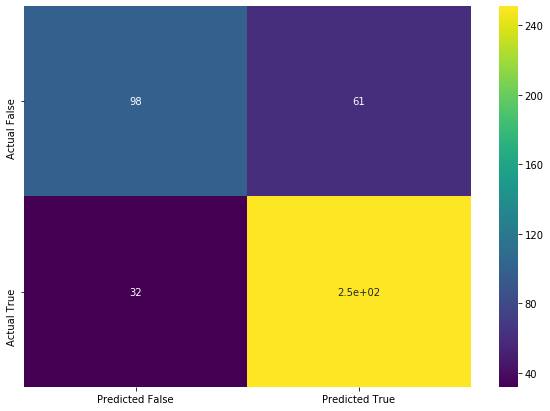

In [68]:
array = confusion_matrix(y_test,predictions_cvec)
df_cm = pd.DataFrame(array, index = [i for i in ['Actual False', 'Actual True']],
                  columns = [i for i in ['Predicted False','Predicted True']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap='viridis');

### Gridsearch over the Tfidf using the transformer 

In [29]:
import pandas as pd
from sklearn.pipeline import Pipeline

pipe = Pipeline([('tfid',TfidfVectorizer()),
               ('transformer', Transformer()),
                ('lr', LogisticRegression())])


# Count Vectorizer is preproccessing so we have to put it in pipeline with something that can 
#scored
pipe_params = {
    'tfid__max_features': [1000, 2500, 3000, 3500],
    'tfid__min_df': [2, 3],
    'tfid__max_df': [.8, .85, .95],
    'tfid__ngram_range': [(1,1), (1,2),(1,4)],
    'lr__penalty': ['l1','l2'],
    'lr__C' :[.01,.1,10,1000]
}

gs_tfid = GridSearchCV(pipe,param_grid=pipe_params, cv=3, n_jobs=-1,verbose=1) # 3 models for each combinations
gs_tfid.fit(X_train['clean_title_selftext'], y_train)
print(gs_cvec.best_score_)


Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:  2.8min finished
/Users/valamani/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.799697656840514


In [32]:
print(gs_tfid.best_params_)
print(f"score for the training data is: {gs_tfid.score(X_train['clean_title_selftext'], y_train)}")
print(f"score for the test data is: {gs_tfid.score(X_test['clean_title_selftext'], y_test)}")
predictions_tfid = gs_tfid.predict(X_test['clean_title_selftext'])
print(f'f1 score is {f1_score(predictions_tfid,y_test)}')      
print(confusion_matrix(y_test, predictions_tfid))   
      
      

{'lr__C': 10, 'lr__penalty': 'l2', 'tfid__max_df': 0.8, 'tfid__max_features': 3500, 'tfid__min_df': 2, 'tfid__ngram_range': (1, 2)}
score for the training data is: 0.9916855631141346
score for the test data is: 0.7895927601809954
f1 score is 0.8436974789915966
[[ 98  61]
 [ 32 251]]


#### Below after changing the target column we can obtain the coefficients to use in graphing in the visualization notebook

In [36]:
# #IMPORTANT: In order to use change the target column to subreddit_vegan This is used for the visualization
# feature_coefficients = dict(zip(gs_cvec.get_feature_names(), np.exp(gs_cvec.coef_[0])))
# vegan_feature_coefficients_df = pd.DataFrame(feature_coefficients.items(),
#                                              columns=['word', 'coefficient'])
# vegan_feature_coefficients_df.to_csv('dataset/vegan_logistic_coef.csv',index=False,
#                                      header=True)


In [ ]:
# #IMPORTANT: In order to use change the target column to subreddit_paleo This is used for the visualization
# feature_coefficients = dict(zip(cvec.get_feature_names(), np.exp(logreg_tfid.coef_[0])))
# paleo_feature_coefficients_df = pd.DataFrame(feature_coefficients.items(), columns=['word', 'coefficient'])
# paleo_feature_coefficients_df.to_csv('dataset/paleo_logistic_coef.csv',index=False, header=True)